### Importing Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.sparse import csr_matrix
from sklearn.neighbors import NearestNeighbors
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.metrics.pairwise import linear_kernel, cosine_similarity
import tensorflow as tf
from tensorflow import keras

### Reading the datasets

In [2]:
ratings = pd.read_csv('C:/Users/ahmet/Desktop/Recommender_Systems/ml-latest-small/ratings.csv')
movies = pd.read_csv('C:/Users/ahmet/Desktop/Recommender_Systems/ml-latest-small/movies.csv')  

In [3]:
ratings.sample(5)

,userId,movieId,rating,timestamp
71726,462,2970,3.0,1129037827
42304,288,1225,4.0,979163436
6918,47,31,3.0,1496205717
60759,391,4967,3.0,1030945731
54168,357,529,3.5,1348611719


In [4]:
ratings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100836 entries, 0 to 100835
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   userId     100836 non-null  int64  
 1   movieId    100836 non-null  int64  
 2   rating     100836 non-null  float64
 3   timestamp  100836 non-null  int64  
dtypes: float64(1), int64(3)
memory usage: 3.1 MB


In [5]:
movies.sample(5)

,movieId,title,genres
355,410,Addams Family Values (1993),Children|Comedy|Fantasy
7036,68932,"Soloist, The (2009)",Drama|Musical
4770,7101,Doc Hollywood (1991),Comedy|Romance
2879,3849,The Spiral Staircase (1945),Horror|Mystery|Thriller
156,185,"Net, The (1995)",Action|Crime|Thriller


In [6]:
movies.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9742 entries, 0 to 9741
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   movieId  9742 non-null   int64 
 1   title    9742 non-null   object
 2   genres   9742 non-null   object
dtypes: int64(1), object(2)
memory usage: 228.5+ KB


# 1. SIMPLE RECOMMENDER

* Recommendation is based on movie rating. 
* Weighted average rating is calculated.
* KNN model is used to suggest closest movies to the watched movie based on weighted average rating. 

In [7]:
df = ratings.merge(movies, on='movieId', how='left')

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 100836 entries, 0 to 100835
Data columns (total 6 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   userId     100836 non-null  int64  
 1   movieId    100836 non-null  int64  
 2   rating     100836 non-null  float64
 3   timestamp  100836 non-null  int64  
 4   title      100836 non-null  object 
 5   genres     100836 non-null  object 
dtypes: float64(1), int64(3), object(2)
memory usage: 5.4+ MB


In [9]:
df_rating = pd.DataFrame(df.groupby('movieId')['rating'].mean()).rename(columns={'rating':'avg_rating'}).reset_index()

In [10]:
df_rating['count_rating'] = pd.DataFrame(df.groupby('movieId')['rating'].count()).rename(columns={'rating':'count_rating'}).reset_index()['count_rating']

In [11]:
df_rating.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9724 entries, 0 to 9723
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   movieId       9724 non-null   int64  
 1   avg_rating    9724 non-null   float64
 2   count_rating  9724 non-null   int64  
dtypes: float64(1), int64(2)
memory usage: 228.0 KB


In [12]:
df_rating.head()

,movieId,avg_rating,count_rating
0,1,3.920930,215
1,2,3.431818,110
2,3,3.259615,52
3,4,2.357143,7
4,5,3.071429,49


In [13]:
df = df.merge(df_rating, on='movieId', how='left')

In [14]:
# Merged dataframe: df

In [15]:
df.sample(5)

,userId,movieId,rating,timestamp,title,genres,avg_rating,count_rating
82468,523,101962,5.0,1507987871,Wolf Children (Okami kodomo no ame to yuki) (2...,Animation|Fantasy,4.000000,4
97843,606,3010,4.0,1171737820,Rosetta (1999),Drama,4.000000,1
64970,414,171763,5.0,1511535821,Baby Driver (2017),Action|Crime|Thriller,4.333333,9
64764,414,69526,2.5,1246413702,Transformers: Revenge of the Fallen (2009),Action|Adventure|Sci-Fi|IMAX,2.425000,20
55619,368,1833,2.0,975829568,Mercury Rising (1998),Action|Drama|Thriller,3.000000,13


In [16]:
# Average of rating

In [17]:
ar_mean = df['avg_rating'].mean()
ar_mean

3.50155698361711

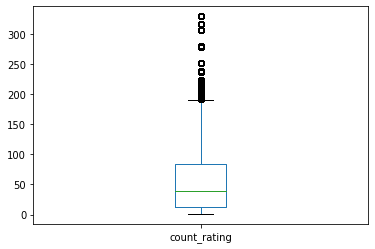

In [18]:
df['count_rating'].plot(kind = 'box');

In [19]:
# the condition to create most rated movies.

In [20]:
cr_condition = df['count_rating'].quantile(0.75)
cr_condition

84.0

In [21]:
df['weighted_average'] = (((df['avg_rating'] * df['count_rating'])+(ar_mean * cr_condition))/(df['count_rating'] + cr_condition))

In [22]:
simple = df[['title','avg_rating','count_rating','weighted_average']].drop_duplicates().sort_values('weighted_average', ascending=False)

In [23]:
simple.head(20)

,title,avg_rating,count_rating,weighted_average
232,"Shawshank Redemption, The (1994)",4.429022,317,4.234740
192,Fight Club (1999),4.272936,218,4.058380
1453,"Godfather, The (1972)",4.289062,192,4.049387
15,Star Wars: Episode IV - A New Hope (1977),4.231076,251,4.048152
16,Pulp Fiction (1994),4.197068,307,4.047649
166,"Matrix, The (1999)",4.192446,278,4.032129
20,Forrest Gump (1994),4.164134,329,4.029372
28,Schindler's List (1993),4.225000,220,4.025101
4,"Usual Suspects, The (1995)",4.237745,204,4.023024
68,Star Wars: Episode V - The Empire Strikes Back...,4.215640,211,4.012308


### KNN Model 

In [24]:
most_rated = simple.set_index('title')

In [25]:
most_rated_matrix = csr_matrix(most_rated.values)

In [26]:
model_knn = NearestNeighbors(metric='cosine', algorithm='brute', n_neighbors=7, n_jobs=-1)
model_knn.fit(most_rated_matrix)

NearestNeighbors(algorithm='brute', metric='cosine', n_jobs=-1, n_neighbors=7)

#### Recommendations based on Simple Recommender

In [27]:
# Let's assume user watched 'Godfather, The (1972)'.

In [28]:
watched_movie = 'Godfather, The (1972)'

In [29]:
query_index = most_rated.index.get_loc(watched_movie)

In [30]:
distances, indices = model_knn.kneighbors(most_rated.loc[watched_movie,:].values.reshape(1, -1), n_neighbors=11)

In [31]:
for i in range(0, len(distances.flatten())):
    if i == 0:
        print('Recommendations for {0}:\n'.format(most_rated.index[query_index]))
    else:
        print('{0}: {1}, with distance of {2}:'.format(i, most_rated.index[indices.flatten()[i]], distances.flatten()[i]))

Recommendations for Godfather, The (1972):

1: Lord of the Rings: The Return of the King, The (2003), with distance of 1.1445399072940177e-08:
2: Saving Private Ryan (1998), with distance of 4.48184830359466e-08:
3: Twelve Monkeys (a.k.a. 12 Monkeys) (1995), with distance of 1.5743659576017421e-07:
4: Sixth Sense, The (1999), with distance of 1.7183546074939215e-07:
5: Fargo (1996), with distance of 2.447947136108297e-07:
6: Mission: Impossible (1996), with distance of 3.5058891079131627e-07:
7: Shrek (2001), with distance of 5.333917980632208e-07:
8: Lord of the Rings: The Two Towers, The (2002), with distance of 6.03069031490655e-07:
9: Lion King, The (1994), with distance of 6.536960288627824e-07:
10: Men in Black (a.k.a. MIB) (1997), with distance of 7.221792531764137e-07:


# 2. CONTENT-BASED RECOMMENDER

* Suggests similar items based on tag and genre.
* Two different vectorizers are used to recommend movies and get similar results.

In [32]:
tags = pd.read_csv('C:/Users/ahmet/Desktop/Recommender_Systems/ml-latest-small/tags.csv')

In [33]:
tags.head(20)

,userId,movieId,tag,timestamp
0,2,60756,funny,1445714994
1,2,60756,Highly quotable,1445714996
2,2,60756,will ferrell,1445714992
3,2,89774,Boxing story,1445715207
4,2,89774,MMA,1445715200
5,2,89774,Tom Hardy,1445715205
6,2,106782,drugs,1445715054
7,2,106782,Leonardo DiCaprio,1445715051
8,2,106782,Martin Scorsese,1445715056
9,7,48516,way too long,1169687325


In [34]:
tags.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3683 entries, 0 to 3682
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   userId     3683 non-null   int64 
 1   movieId    3683 non-null   int64 
 2   tag        3683 non-null   object
 3   timestamp  3683 non-null   int64 
dtypes: int64(3), object(1)
memory usage: 115.2+ KB


In [35]:
tags = tags.dropna()

In [36]:
df_tags = df.copy()

In [37]:
df_tags.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 100836 entries, 0 to 100835
Data columns (total 9 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   userId            100836 non-null  int64  
 1   movieId           100836 non-null  int64  
 2   rating            100836 non-null  float64
 3   timestamp         100836 non-null  int64  
 4   title             100836 non-null  object 
 5   genres            100836 non-null  object 
 6   avg_rating        100836 non-null  float64
 7   count_rating      100836 non-null  int64  
 8   weighted_average  100836 non-null  float64
dtypes: float64(3), int64(4), object(2)
memory usage: 7.7+ MB


In [38]:
# tags dataframe is merged with df.

In [39]:
df_tags = df_tags.merge(tags[['movieId','tag']], on='movieId')

In [40]:
df_tags.head(10)

,userId,movieId,rating,timestamp,title,genres,avg_rating,count_rating,weighted_average,tag
0,1,1,4.0,964982703,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,3.92093,215,3.803113,pixar
1,1,1,4.0,964982703,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,3.92093,215,3.803113,pixar
2,1,1,4.0,964982703,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,3.92093,215,3.803113,fun
3,5,1,4.0,847434962,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,3.92093,215,3.803113,pixar
4,5,1,4.0,847434962,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,3.92093,215,3.803113,pixar
5,5,1,4.0,847434962,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,3.92093,215,3.803113,fun
6,7,1,4.5,1106635946,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,3.92093,215,3.803113,pixar
7,7,1,4.5,1106635946,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,3.92093,215,3.803113,pixar
8,7,1,4.5,1106635946,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,3.92093,215,3.803113,fun
9,15,1,2.5,1510577970,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,3.92093,215,3.803113,pixar


### Preparing Data for Vectorization

In [41]:
content = df_tags[['title','tag']].drop_duplicates().groupby('title')['tag'].apply(','.join).reset_index()

In [42]:
content

,title,tag
0,(500) Days of Summer (2009),"artistic,Funny,humorous,inspiring,intelligent,..."
1,...And Justice for All (1979),lawyers
2,10 Cloverfield Lane (2016),"creepy,suspense"
3,10 Things I Hate About You (1999),Shakespeare sort of
4,101 Dalmatians (1996),"dogs,remake"
...,...,...
1549,Zero Dark Thirty (2012),"Afghanistan,American propaganda,assassination,..."
1550,Zombieland (2009),"Bill Murray,dark comedy,Emma Stone,funny,Jesse..."
1551,Zoolander (2001),"ben stiller,comedy,David Bowie,goofy,mindless ..."
1552,Zulu (1964),Africa


In [43]:
content = content.merge(df_tags[['title', 'genres']].drop_duplicates(), on='title', how='inner')

In [44]:
content

,title,tag,genres
0,(500) Days of Summer (2009),"artistic,Funny,humorous,inspiring,intelligent,...",Comedy|Drama|Romance
1,...And Justice for All (1979),lawyers,Drama|Thriller
2,10 Cloverfield Lane (2016),"creepy,suspense",Thriller
3,10 Things I Hate About You (1999),Shakespeare sort of,Comedy|Romance
4,101 Dalmatians (1996),"dogs,remake",Adventure|Children|Comedy
...,...,...,...
1549,Zero Dark Thirty (2012),"Afghanistan,American propaganda,assassination,...",Action|Drama|Thriller
1550,Zombieland (2009),"Bill Murray,dark comedy,Emma Stone,funny,Jesse...",Action|Comedy|Horror
1551,Zoolander (2001),"ben stiller,comedy,David Bowie,goofy,mindless ...",Comedy
1552,Zulu (1964),Africa,Action|Drama|War


In [45]:
def clean_comma(x):
    if isinstance(x, list):
        return [str.lower(i.replace(",", " ")) for i in x]
    else:
        #Check if director exists. If not, return empty string
        if isinstance(x, str):
            return str.lower(x.replace(",", " "))
        else:
            return ''

In [46]:
def clean_or(x):
    if isinstance(x, list):
        return [str.lower(i.replace("|", " ")) for i in x]
    else:
        #Check if director exists. If not, return empty string
        if isinstance(x, str):
            return str.lower(x.replace("|", " "))
        else:
            return ''

In [47]:
content['tag'] = content['tag'].apply(clean_comma)

In [48]:
content['genres'] = content['genres'].apply(clean_or)

In [49]:
content

,title,tag,genres
0,(500) Days of Summer (2009),artistic funny humorous inspiring intelligent ...,comedy drama romance
1,...And Justice for All (1979),lawyers,drama thriller
2,10 Cloverfield Lane (2016),creepy suspense,thriller
3,10 Things I Hate About You (1999),shakespeare sort of,comedy romance
4,101 Dalmatians (1996),dogs remake,adventure children comedy
...,...,...,...
1549,Zero Dark Thirty (2012),afghanistan american propaganda assassination ...,action drama thriller
1550,Zombieland (2009),bill murray dark comedy emma stone funny jesse...,action comedy horror
1551,Zoolander (2001),ben stiller comedy david bowie goofy mindless ...,comedy
1552,Zulu (1964),africa,action drama war


In [50]:
def combine(x):
    return ''.join(x['tag']) + ' ' + ''.join(x['genres'])

In [51]:
content['combined'] = content.apply(combine, axis=1)

In [52]:
content

,title,tag,genres,combined
0,(500) Days of Summer (2009),artistic funny humorous inspiring intelligent ...,comedy drama romance,artistic funny humorous inspiring intelligent ...
1,...And Justice for All (1979),lawyers,drama thriller,lawyers drama thriller
2,10 Cloverfield Lane (2016),creepy suspense,thriller,creepy suspense thriller
3,10 Things I Hate About You (1999),shakespeare sort of,comedy romance,shakespeare sort of comedy romance
4,101 Dalmatians (1996),dogs remake,adventure children comedy,dogs remake adventure children comedy
...,...,...,...,...
1549,Zero Dark Thirty (2012),afghanistan american propaganda assassination ...,action drama thriller,afghanistan american propaganda assassination ...
1550,Zombieland (2009),bill murray dark comedy emma stone funny jesse...,action comedy horror,bill murray dark comedy emma stone funny jesse...
1551,Zoolander (2001),ben stiller comedy david bowie goofy mindless ...,comedy,ben stiller comedy david bowie goofy mindless ...
1552,Zulu (1964),africa,action drama war,africa action drama war


### a. TF-IDF Vectorizer

In [53]:
tfidf = TfidfVectorizer(stop_words='english')

In [54]:
tfidf_matrix = tfidf.fit_transform(content['combined'])

In [55]:
tfidf_matrix.shape

(1554, 1675)

In [56]:
cosine_sim = linear_kernel(tfidf_matrix, tfidf_matrix)

In [57]:
cosine_sim.shape

(1554, 1554)

In [58]:
cosine_sim[1]

array([0.01757195, 1.        , 0.11521301, ..., 0.        , 0.04185061,
       0.08330907])

In [59]:
new_index = pd.Series(content.index, index=content['title'])

In [60]:
new_index[:20]

title
(500) Days of Summer (2009)                                0
...And Justice for All (1979)                              1
10 Cloverfield Lane (2016)                                 2
10 Things I Hate About You (1999)                          3
101 Dalmatians (1996)                                      4
101 Dalmatians (One Hundred and One Dalmatians) (1961)     5
11'09"01 - September 11 (2002)                             6
12 Angry Men (1957)                                        7
127 Hours (2010)                                           8
13 Going on 30 (2004)                                      9
2001: A Space Odyssey (1968)                              10
21 Grams (2003)                                           11
25th Hour (2002)                                          12
28 Days Later (2002)                                      13
39 Steps, The (1935)                                      14
3:10 to Yuma (2007)                                       15
40-Year-Old Virgin

### Recommendation Function

In [61]:
def get_recommendations(title, cosine_sim=cosine_sim):
    # Get the index of the movie that matches the title
    idx = new_index[title]

    # Get the pairwsie similarity scores of all movies with that movie
    sim_scores = list(enumerate(cosine_sim[idx]))

    # Sort the movies based on the similarity scores
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)

    # Get the scores of the 10 most similar movies
    sim_scores = sim_scores[1:11]

    # Get the movie indices
    movie_indices = [i[0] for i in sim_scores]

    # Return the top 10 most similar movies
    return content['title'].iloc[movie_indices]

#### Recommendations based on Content-Based Recommender

In [62]:
get_recommendations('Godfather, The (1972)')

364              Donnie Brasco (1997)
515             Godfather, The (1972)
532                 Goodfellas (1990)
834         Married to the Mob (1988)
913             My Blue Heaven (1990)
870          Miller's Crossing (1990)
516    Godfather: Part II, The (1974)
226              Carlito's Way (1993)
56           American Gangster (2007)
124             Beat the Devil (1953)
Name: title, dtype: object

### b. Count Vectorizer

In [63]:
count = CountVectorizer(stop_words='english')

In [64]:
count_matrix = count.fit_transform(content['combined'])

In [65]:
count_matrix.shape

(1554, 1675)

In [66]:
cosine_sim2 = cosine_similarity(count_matrix, count_matrix)

#### Recommendations based on Content-Based Recommender

In [67]:
get_recommendations('Godfather, The (1972)', cosine_sim2)

364              Donnie Brasco (1997)
515             Godfather, The (1972)
532                 Goodfellas (1990)
516    Godfather: Part II, The (1974)
12                   25th Hour (2002)
226              Carlito's Way (1993)
870          Miller's Crossing (1990)
56           American Gangster (2007)
92         Au Hasard Balthazar (1966)
136       Better Luck Tomorrow (2002)
Name: title, dtype: object

# 3. COLLABORATIVE FILTERING

* Try to predict the rating that a user would give based on past ratings of other users.
* Created embedding layer having embedding vectors of users and movies.

### Preparing Data

In [68]:
ratings.sample(5)

,userId,movieId,rating,timestamp
23217,159,103141,3.0,1508640379
1131,10,2671,3.5,1455357517
87216,562,4034,4.5,1368895142
49736,318,100044,4.0,1426414317
19697,129,648,4.0,1167376093


In [69]:
# Map user ID to a "user vector" via an embedding matrix
user_ids = ratings["userId"].unique().tolist()
user2user_encoded = {x: i for i, x in enumerate(user_ids)}

In [70]:
# Map movies ID to a "movies vector" via an embedding matrix
movie_ids = ratings["movieId"].unique().tolist()
movie2movie_encoded = {x: i for i, x in enumerate(movie_ids)}

In [71]:
ratings["user"] = ratings["userId"].map(user2user_encoded)
ratings["movie"] = ratings["movieId"].map(movie2movie_encoded)

In [72]:
num_users = len(user2user_encoded)
num_movies = len(movie2movie_encoded)
ratings['rating'] = ratings['rating'].values.astype(np.float32)

In [73]:
# min and max ratings will be used to normalize the ratings later
min_rating = min(ratings["rating"])
max_rating = max(ratings["rating"])

In [74]:
print(f"Number of users: {num_users}, Number of Movies: {num_movies}, Min Rating: {min_rating}, Max Rating: {max_rating}")

Number of users: 610, Number of Movies: 9724, Min Rating: 0.5, Max Rating: 5.0


In [75]:
# Normalizing the targets between 0 and 1. Makes it easy to train.
ratings["rating"] = ratings["rating"].apply(lambda x: (x - min_rating) / (max_rating - min_rating))

In [76]:
ratings

,userId,movieId,rating,timestamp,user,movie
0,1,1,0.777778,964982703,0,0
1,1,3,0.777778,964981247,0,1
2,1,6,0.777778,964982224,0,2
3,1,47,1.000000,964983815,0,3
4,1,50,1.000000,964982931,0,4
...,...,...,...,...,...,...
100831,610,166534,0.777778,1493848402,609,3120
100832,610,168248,1.000000,1493850091,609,2035
100833,610,168250,1.000000,1494273047,609,3121
100834,610,168252,1.000000,1493846352,609,1392


In [77]:
# Assuming training except for the last 5 ratings and validating the last 5 ratings
train = ratings.sort_values(['userId','timestamp'],ascending=True).groupby('userId').apply(lambda x:x.iloc[5:]).set_index(np.arange(97786))
test = ratings.sort_values(['userId','timestamp'],ascending=True).groupby('userId').apply(lambda x:x.iloc[:5]).set_index(np.arange(3050))

In [78]:
X_train = train[["user", "movie"]].values
X_val = test[["user", "movie"]].values
y_train = train["rating"].values
y_val = test["rating"].values

### Model

In [79]:
class CollaborativeRecommender(keras.Model):
    
    def __init__(self, num_users, num_movies, embedding_size, **kwargs):
        super(CollaborativeRecommender, self).__init__(**kwargs)
        self.num_users = num_users
        self.num_movies = num_movies
        self.embedding_size = embedding_size
        self.user_embedding = keras.layers.Embedding(
            num_users,
            embedding_size,
            embeddings_initializer="lecun_normal",
            embeddings_regularizer=keras.regularizers.l2(),
        )
        self.user_bias = keras.layers.Embedding(num_users, 1)
        
        self.movie_embedding = keras.layers.Embedding(
            num_movies,
            embedding_size,
            embeddings_initializer="lecun_normal",
            embeddings_regularizer=keras.regularizers.l2()
        )
        self.movie_bias = keras.layers.Embedding(num_movies, 1)
        
    def call(self, inputs):
        user_vector = self.user_embedding(inputs[:, 0])
        user_bias = self.user_bias(inputs[:, 0])
        movie_vector = self.movie_embedding(inputs[:, 1])
        movie_bias = self.movie_bias(inputs[:, 1])
        dot_user_movie = tf.tensordot(user_vector, movie_vector, 2)
        # Add all the components (including bias)
        x = dot_user_movie + user_bias + movie_bias
        # The sigmoid activation forces the rating to be between 0 and 1
        return tf.nn.sigmoid(x)

In [80]:
EMBEDDING_SIZE = 100

In [81]:
model = CollaborativeRecommender(num_users, num_movies, EMBEDDING_SIZE)
model.compile(
    loss=tf.keras.losses.MeanSquaredError(), 
    optimizer=keras.optimizers.Adam(),
    metrics=["accuracy", tf.keras.metrics.Recall(), tf.keras.metrics.Precision()]
)

In [82]:
trained_model = model.fit(
    x = X_train,
    y = y_train,
    epochs = 5,
    verbose = 1,
    validation_data = (X_val, y_val)
)

Epoch 1/5
3056/3056 [==============================] - 21s 7ms/step - loss: 0.0680 - accuracy: 0.1289 - recall: 0.9117 - precision: 0.9902 - val_loss: 0.0599 - val_accuracy: 0.2102 - val_recall: 0.9840 - val_precision: 0.9860
Epoch 2/5
3056/3056 [==============================] - 20s 7ms/step - loss: 0.0417 - accuracy: 0.1327 - recall: 0.9248 - precision: 0.9911 - val_loss: 0.0515 - val_accuracy: 0.2115 - val_recall: 0.9787 - val_precision: 0.9875
Epoch 3/5
3056/3056 [==============================] - 20s 7ms/step - loss: 0.0375 - accuracy: 0.1334 - recall: 0.9164 - precision: 0.9916 - val_loss: 0.0492 - val_accuracy: 0.2115 - val_recall: 0.9713 - val_precision: 0.9878
Epoch 4/5
3056/3056 [==============================] - 20s 7ms/step - loss: 0.0357 - accuracy: 0.1339 - recall: 0.9085 - precision: 0.9922 - val_loss: 0.0483 - val_accuracy: 0.2128 - val_recall: 0.9650 - val_precision: 0.9887
Epoch 5/5
3056/3056 [==============================] - 20s 7ms/step - loss: 0.0347 - accuracy: 0

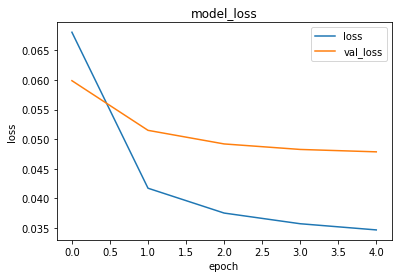

In [83]:
plt.plot(trained_model.history['loss'], label='loss')
plt.plot(trained_model.history['val_loss'], label='val_loss')
plt.title('model_loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend();

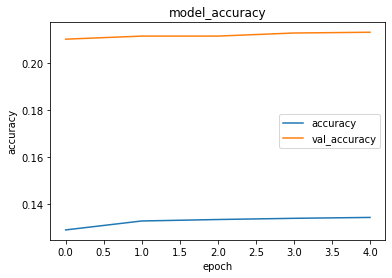

In [84]:
plt.plot(trained_model.history['accuracy'], label='accuracy')
plt.plot(trained_model.history['val_accuracy'], label='val_accuracy')
plt.title('model_accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend();

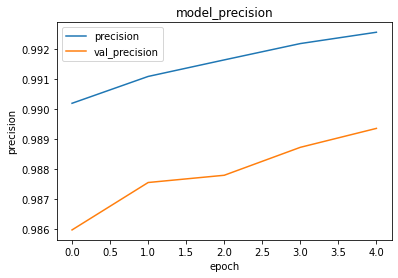

In [85]:
plt.plot(trained_model.history['precision'], label='precision')
plt.plot(trained_model.history['val_precision'], label='val_precision')
plt.title('model_precision')
plt.ylabel('precision')
plt.xlabel('epoch')
plt.legend();

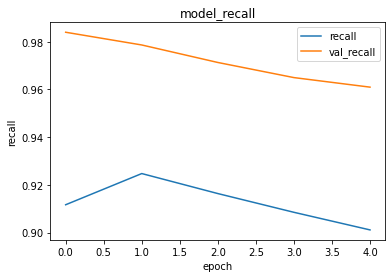

In [86]:
plt.plot(trained_model.history['recall'], label='recall')
plt.plot(trained_model.history['val_recall'], label='val_recall')
plt.title('model_recall')
plt.ylabel('recall')
plt.xlabel('epoch')
plt.legend();

#### Recommendations based on Collaborative Filtering

In [87]:
def recommend_movie(sample_user_id):
    movies_watched_by_user = ratings[ratings.userId == sample_user_id]
    movies_not_watched = movies[~movies['movieId'].isin(movies_watched_by_user.movieId.values)]['movieId']
    movies_not_watched = list(set(movies_not_watched).intersection(set(movie2movie_encoded.keys())))
    movies_not_watched = [[movie2movie_encoded.get(x)] for x in movies_not_watched]
    user_encoder = user2user_encoded.get(sample_user_id)
    user_movie_array = np.hstack(([[user_encoder]] * len(movies_not_watched), movies_not_watched))
    recommendations = model.predict(user_movie_array).flatten()
    top_ratings_indices = recommendations.argsort()[-6:][::-1]
    recommended_movie_ids = [movie2movie_encoded.get(movies_not_watched[x][0]) for x in top_ratings_indices]
    return movies[movies["movieId"].isin(recommended_movie_ids)]

In [88]:
sample_user_id = df.userId.sample(1).iloc[0]
sample_user_id

328

In [89]:
recommend_movie(sample_user_id)

,movieId,title,genres
126,153,Batman Forever (1995),Action|Adventure|Comedy|Crime
401,460,Getting Even with Dad (1994),Comedy


In [90]:
print("Showing recommendations for user: {}".format(sample_user_id))
print("-------" * 5)
print("The last 5 movies rated by the user")
print("-------" * 5)
trail = test[test.userId == sample_user_id].movieId.values
movies_rows = movies[movies["movieId"].isin(trail)]
for row in movies_rows.itertuples():
    print(row.title, ":", row.genres)

print("-------" * 5)
print("The top 5 movies recommendations")
print("-------" * 5)
recommended_movies = recommend_movie(sample_user_id)
for row in recommended_movies.itertuples():
    print(row.title, ":", row.genres)

Showing recommendations for user: 328
-----------------------------------
The last 5 movies rated by the user
-----------------------------------
Usual Suspects, The (1995) : Crime|Mystery|Thriller
Shawshank Redemption, The (1994) : Crime|Drama
Godfather, The (1972) : Crime|Drama
Fight Club (1999) : Action|Crime|Drama|Thriller
Dark Knight, The (2008) : Action|Crime|Drama|IMAX
-----------------------------------
The top 5 movies recommendations
-----------------------------------
Batman Forever (1995) : Action|Adventure|Comedy|Crime
Getting Even with Dad (1994) : Comedy
